In [1]:
from hossam import *
from pandas import DataFrame, Series
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from itertools import product

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler

# 성능 평가 지표 모듈
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

# 랜덤포레스트
from sklearn.ensemble import RandomForestRegressor

import sys

sys.path.append("/Users/jinwoo/Machine_Learning")

from hs_eval_utils import (
    hs_get_scores,
    hs_learning_cv,
    hs_get_score_cv,
    feature_importance,
    hs_shap_analysis,
)

from sklearn.tree import DecisionTreeRegressor

import shap

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor

In [2]:
origin = load_data("restaurant_sales_preprocessed")
origin.set_index("date", inplace=True)
origin["holiday"] = origin["holiday"].astype("int")
origin["weekend"] = origin["weekend"].astype("int")
origin.info()

어느 식당의 1년간 일별 매출을 기록한 데이터의 전처리 완료 버전(명목형이 이진변수만 있으므로 더미변수는 처리하지 않음)
<class 'pandas.DataFrame'>
DatetimeIndex: 353 entries, 2024-01-01 to 2024-12-30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sales           353 non-null    float64
 1   visitors        353 non-null    int64  
 2   avg_price       353 non-null    int64  
 3   marketing_cost  353 non-null    float64
 4   delivery_ratio  353 non-null    float64
 5   rain_mm         353 non-null    float64
 6   temperature     353 non-null    float64
 7   holiday         353 non-null    int64  
 8   weekend         353 non-null    int64  
dtypes: float64(5), int64(4)
memory usage: 27.6 KB


In [3]:
df = origin
yname = "sales"
x = df.drop(columns=[yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=52
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((264, 8), (89, 8), (264,), (89,))

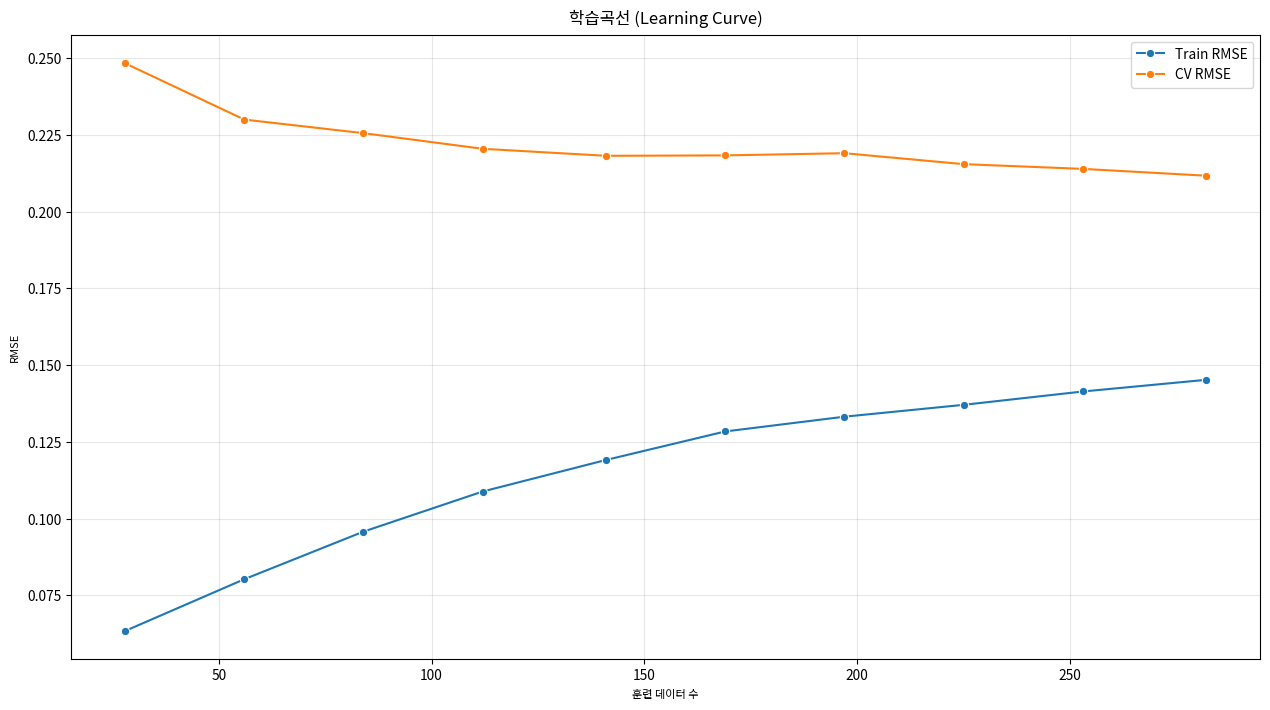

CPU times: user 5.72 s, sys: 935 ms, total: 6.65 s
Wall time: 1min 12s


,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE),Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
XGBRegressor,0.862,0.110,0.020,0.142,0.007,-0.016,0.145,0.212,0.012,0.686,0.058,⚠️ 과대적합 (variance 큼)


In [4]:
%%time

xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=52,
    n_jobs=-1,
    tree_method="hist"
)

# 실습 상황임을 고려하여 하이퍼파라미터 탐색 범위를 축소
param_grid = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [1, 5, 10],
}

gs = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

gs.fit(x_train, y_train)

best_model = gs.best_estimator_

hs_get_score_cv(best_model, x_train, y_train, x, y)


In [5]:
booster = best_model.get_booster()

imp = booster.get_score(importance_type="gain")
imp

{'visitors': 0.11625449359416962,
 'avg_price': 0.17859311401844025,
 'marketing_cost': 0.24400131404399872,
 'delivery_ratio': 0.10611158609390259,
 'rain_mm': 0.17931751906871796,
 'temperature': 0.10911962389945984,
 'holiday': 1.6687114238739014,
 'weekend': 2.6015374660491943}

In [6]:
imp_sr = Series(imp)
imp_sr

visitors         0.116
avg_price        0.179
marketing_cost   0.244
delivery_ratio   0.106
rain_mm          0.179
temperature      0.109
holiday          1.669
weekend          2.602
dtype: float64

In [8]:
imp_df = DataFrame(imp_sr, columns=["importance"])
imp_df = imp_df.sort_values("importance", ascending=False)
imp_df

,importance
weekend,2.602
holiday,1.669
marketing_cost,0.244
rain_mm,0.179
avg_price,0.179
visitors,0.116
temperature,0.109
delivery_ratio,0.106


In [9]:
imp_df["ratio"] = imp_df["importance"] / imp_df["importance"].sum()
imp_df["cumsum"] = imp_df["ratio"].cumsum()
imp_df

,importance,ratio,cumsum
weekend,2.602,0.500,0.500
holiday,1.669,0.321,0.821
marketing_cost,0.244,0.047,0.868
rain_mm,0.179,0.034,0.902
avg_price,0.179,0.034,0.936
visitors,0.116,0.022,0.959
temperature,0.109,0.021,0.980
delivery_ratio,0.106,0.020,1.000


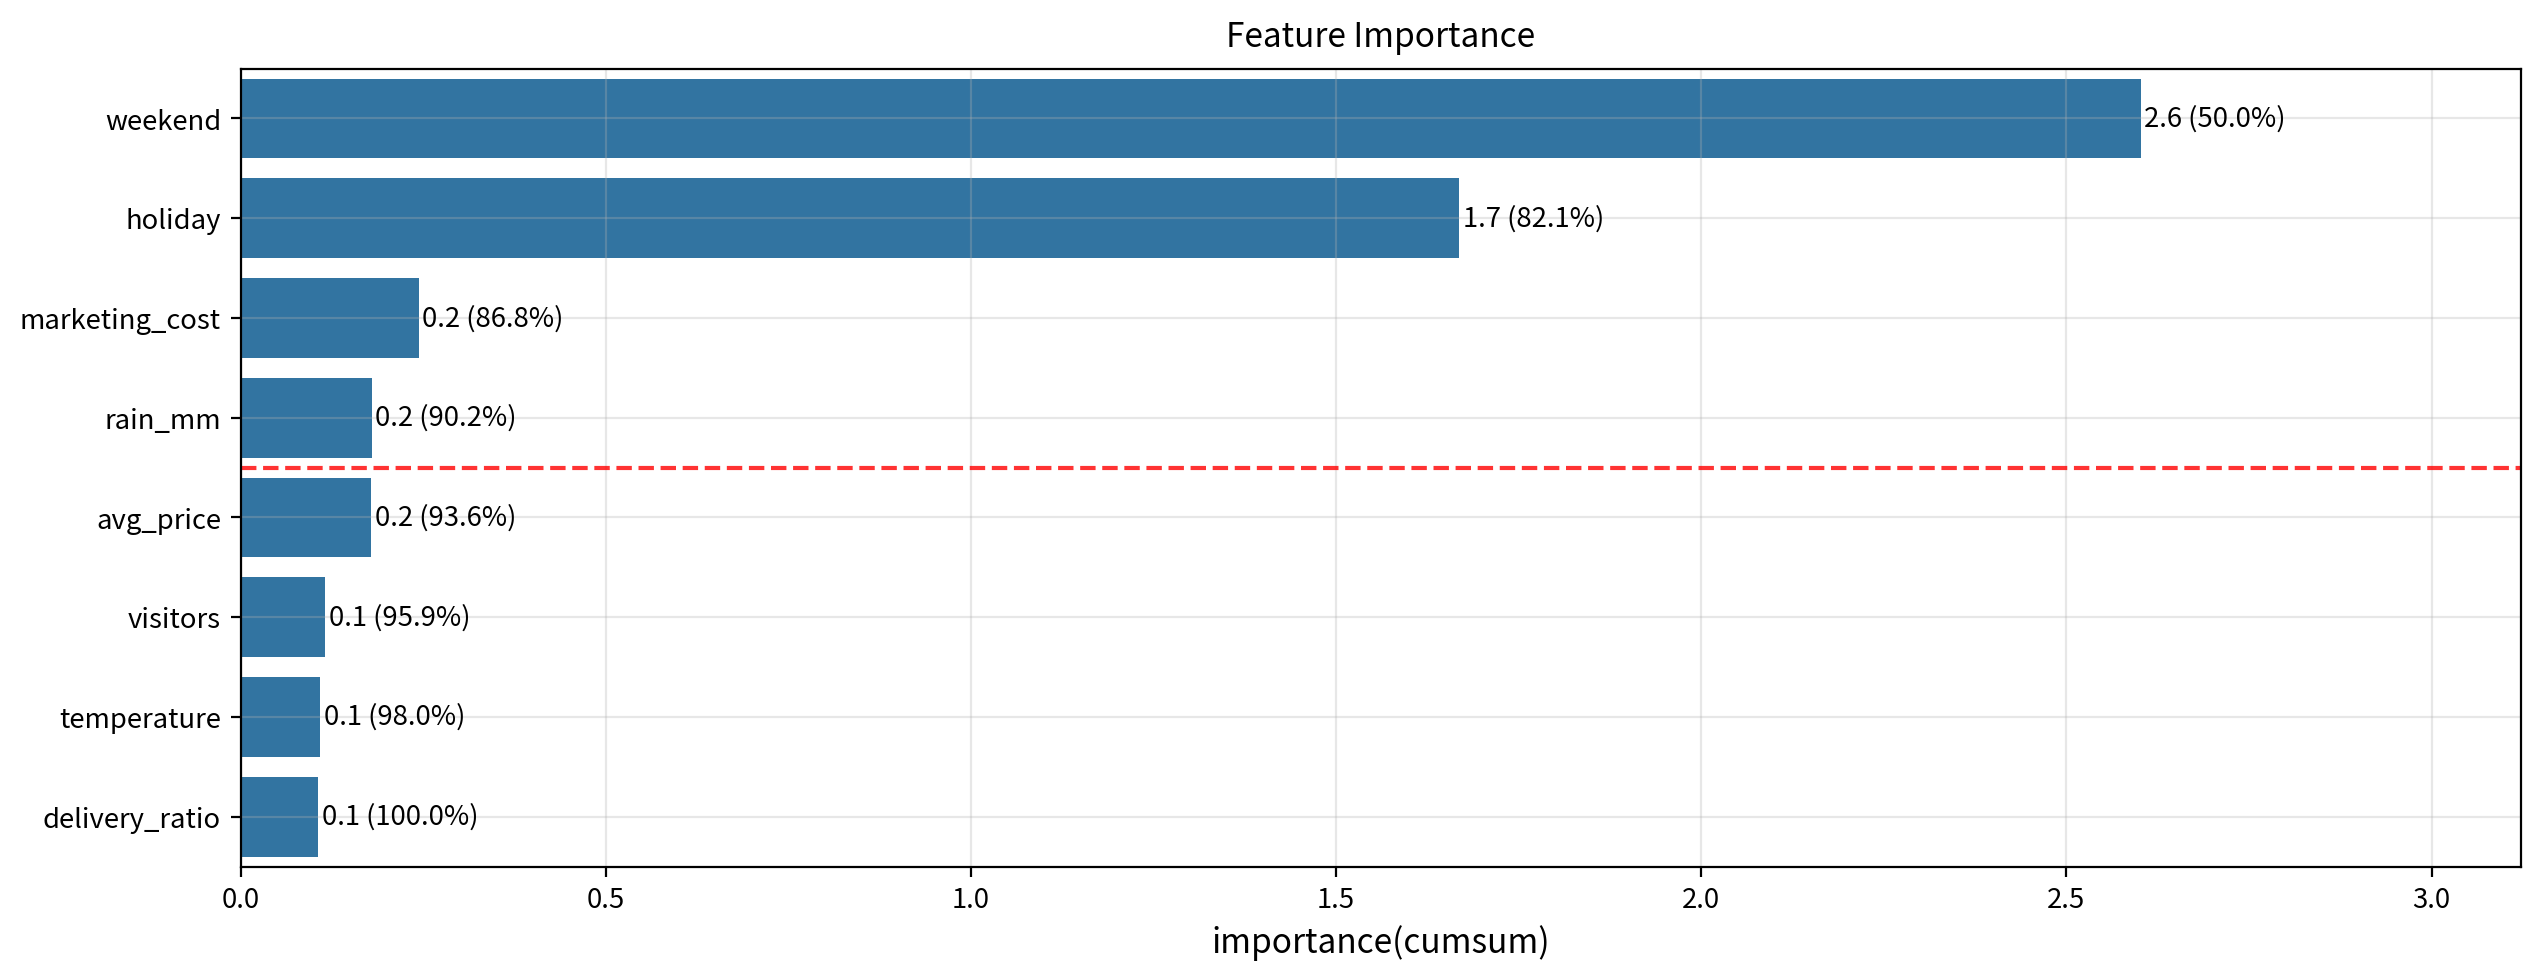

In [10]:
df = imp_df.sort_values(by="ratio", ascending=False)
threshold = 0.9

figsize = (1280 / 100, 500 / 100)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.barplot(data=df, x="importance", y=df.index)

# 값 라벨 추가
for i, v in enumerate(imp_df["importance"]):
    ax.text(
        v + 0.005,  # 막대 끝에서 약간 오른쪽
        i,  # y 위치
        f"{v:.1f} ({imp_df.iloc[i]['cumsum']*100:.1f}%)",  # 표시 형식
        va="center",
    )

ax.set_title("Feature Importance", fontsize=12, pad=8)
ax.set_xlabel("importance(cumsum)", fontsize=12)
ax.set_ylabel(None)
ax.grid(True, alpha=0.3)

ax.set_xlim(0, imp_df["importance"].max() * 1.2)

# 90% 처음 도달하는 인덱스 (0-based)
cut_idx = np.argmax(imp_df["cumsum"].values >= threshold)

# 주황색 rank 기준으로 +1
cut_rank = (int(cut_idx) + 1) - 0.5

# 90% 도달 지점 수직선 (핵심)
plt.axhline(
    y=cut_rank,
    linestyle="--",
    color="red",
    alpha=0.8,
)

plt.tight_layout()
plt.show()
plt.close()

In [11]:
def hs_feature_importance(model, x_train, y_train):
    if isinstance(model, XGBRegressor):
        booster = model.get_booster()
        imp = booster.get_score(importance_type="gain")
        imp_sr = Series(imp)
        imp_df = DataFrame(imp_sr, columns=["importance"])
    else:
        imp_df = permutation_importance(
            estimator=best_model,
            X=x_train,
            y=y_train,
            scoring="r2",
            n_repeats=30,
            random_state=42,
            n_jobs=-1,
        )

        # 결과 정리
        imp_df = DataFrame(
            {"importance": imp_df.importances_mean}, index=x_train.columns
        )

    # 중요도 비율 + 누적 중요도 계산
    imp_df["ratio"] = imp_df["importance"] / imp_df["importance"].sum()
    imp_df.sort_values("ratio", ascending=False, inplace=True)
    imp_df["cumsum"] = imp_df["ratio"].cumsum()

    # 시각화
    df = imp_df.sort_values(by="ratio", ascending=False)
    threshold = 0.9

    height = len(imp_df) * 60
    figsize = (1280 / 100, height / 100)
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

    sb.barplot(data=df, x="importance", y=df.index)

    # 값 라벨 추가
    for i, v in enumerate(imp_df["importance"]):
        ax.text(
            v + 0.005,  # 막대 끝에서 약간 오른쪽
            i,  # y 위치
            f"{v:.1f} ({imp_df.iloc[i]['cumsum']*100:.1f}%)",  # 표시 형식
            va="center",
        )

    ax.set_title("Feature Importance", fontsize=9)
    ax.set_xlabel("importance(cumsum)", fontsize=9)
    ax.set_ylabel(None)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, imp_df["importance"].max() * 1.2)

    # 90% 처음 도달하는 인덱스 (0-based)
    cut_idx = np.argmax(imp_df["cumsum"].values >= threshold)

    # 주황색 rank 기준으로 +1
    cut_rank = (int(cut_idx) + 1) - 0.5

    # 90% 도달 지점 수직선 (핵심)
    plt.axhline(
        y=cut_rank,
        linestyle="--",
        color="red",
        alpha=0.8,
    )

    plt.tight_layout()
    plt.show()
    plt.close()

    return imp_df

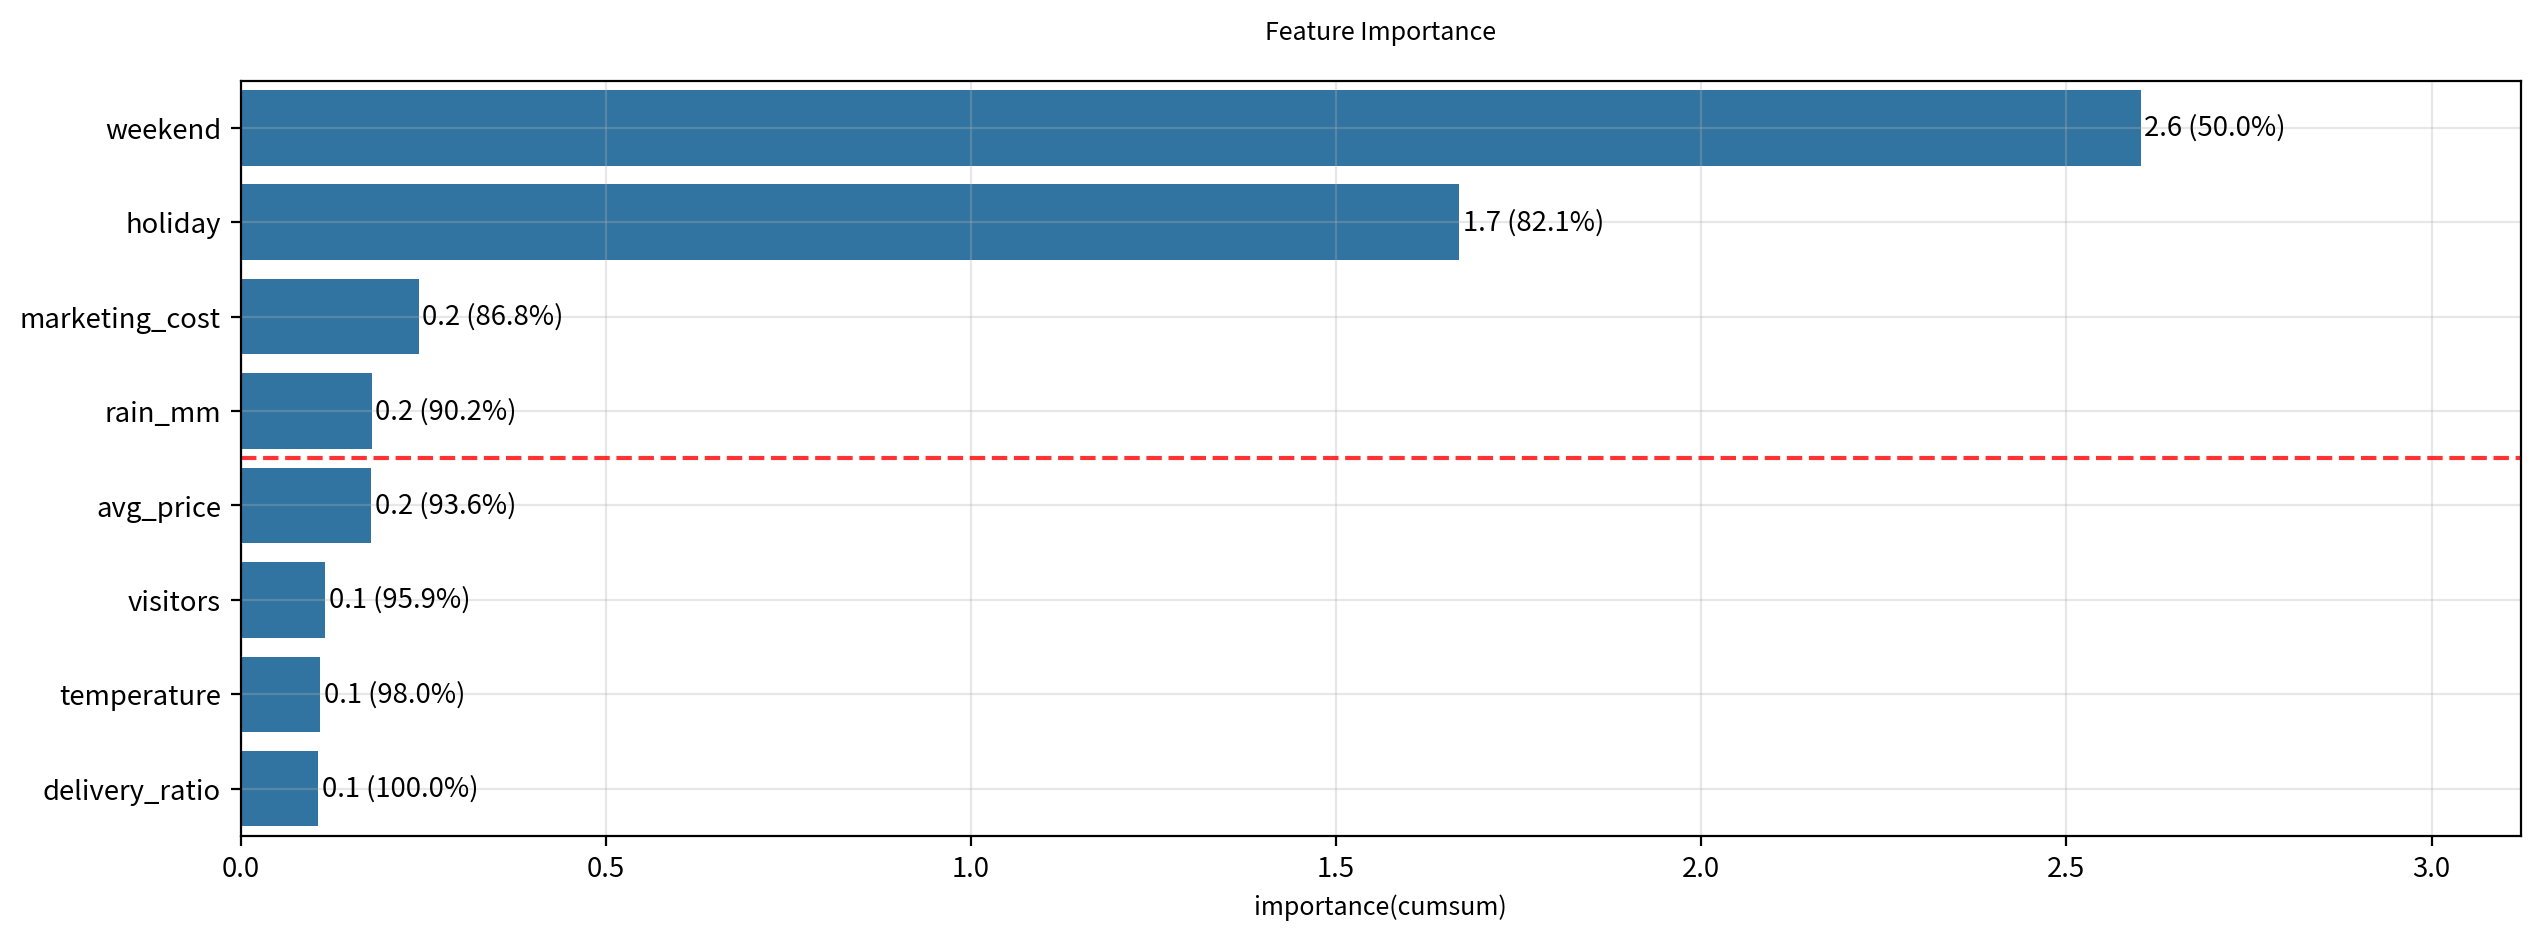

,importance,ratio,cumsum
weekend,2.602,0.500,0.500
holiday,1.669,0.321,0.821
marketing_cost,0.244,0.047,0.868
rain_mm,0.179,0.034,0.902
avg_price,0.179,0.034,0.936
visitors,0.116,0.022,0.959
temperature,0.109,0.021,0.980
delivery_ratio,0.106,0.020,1.000


In [12]:
hs_feature_importance(best_model, x_train, y_train)

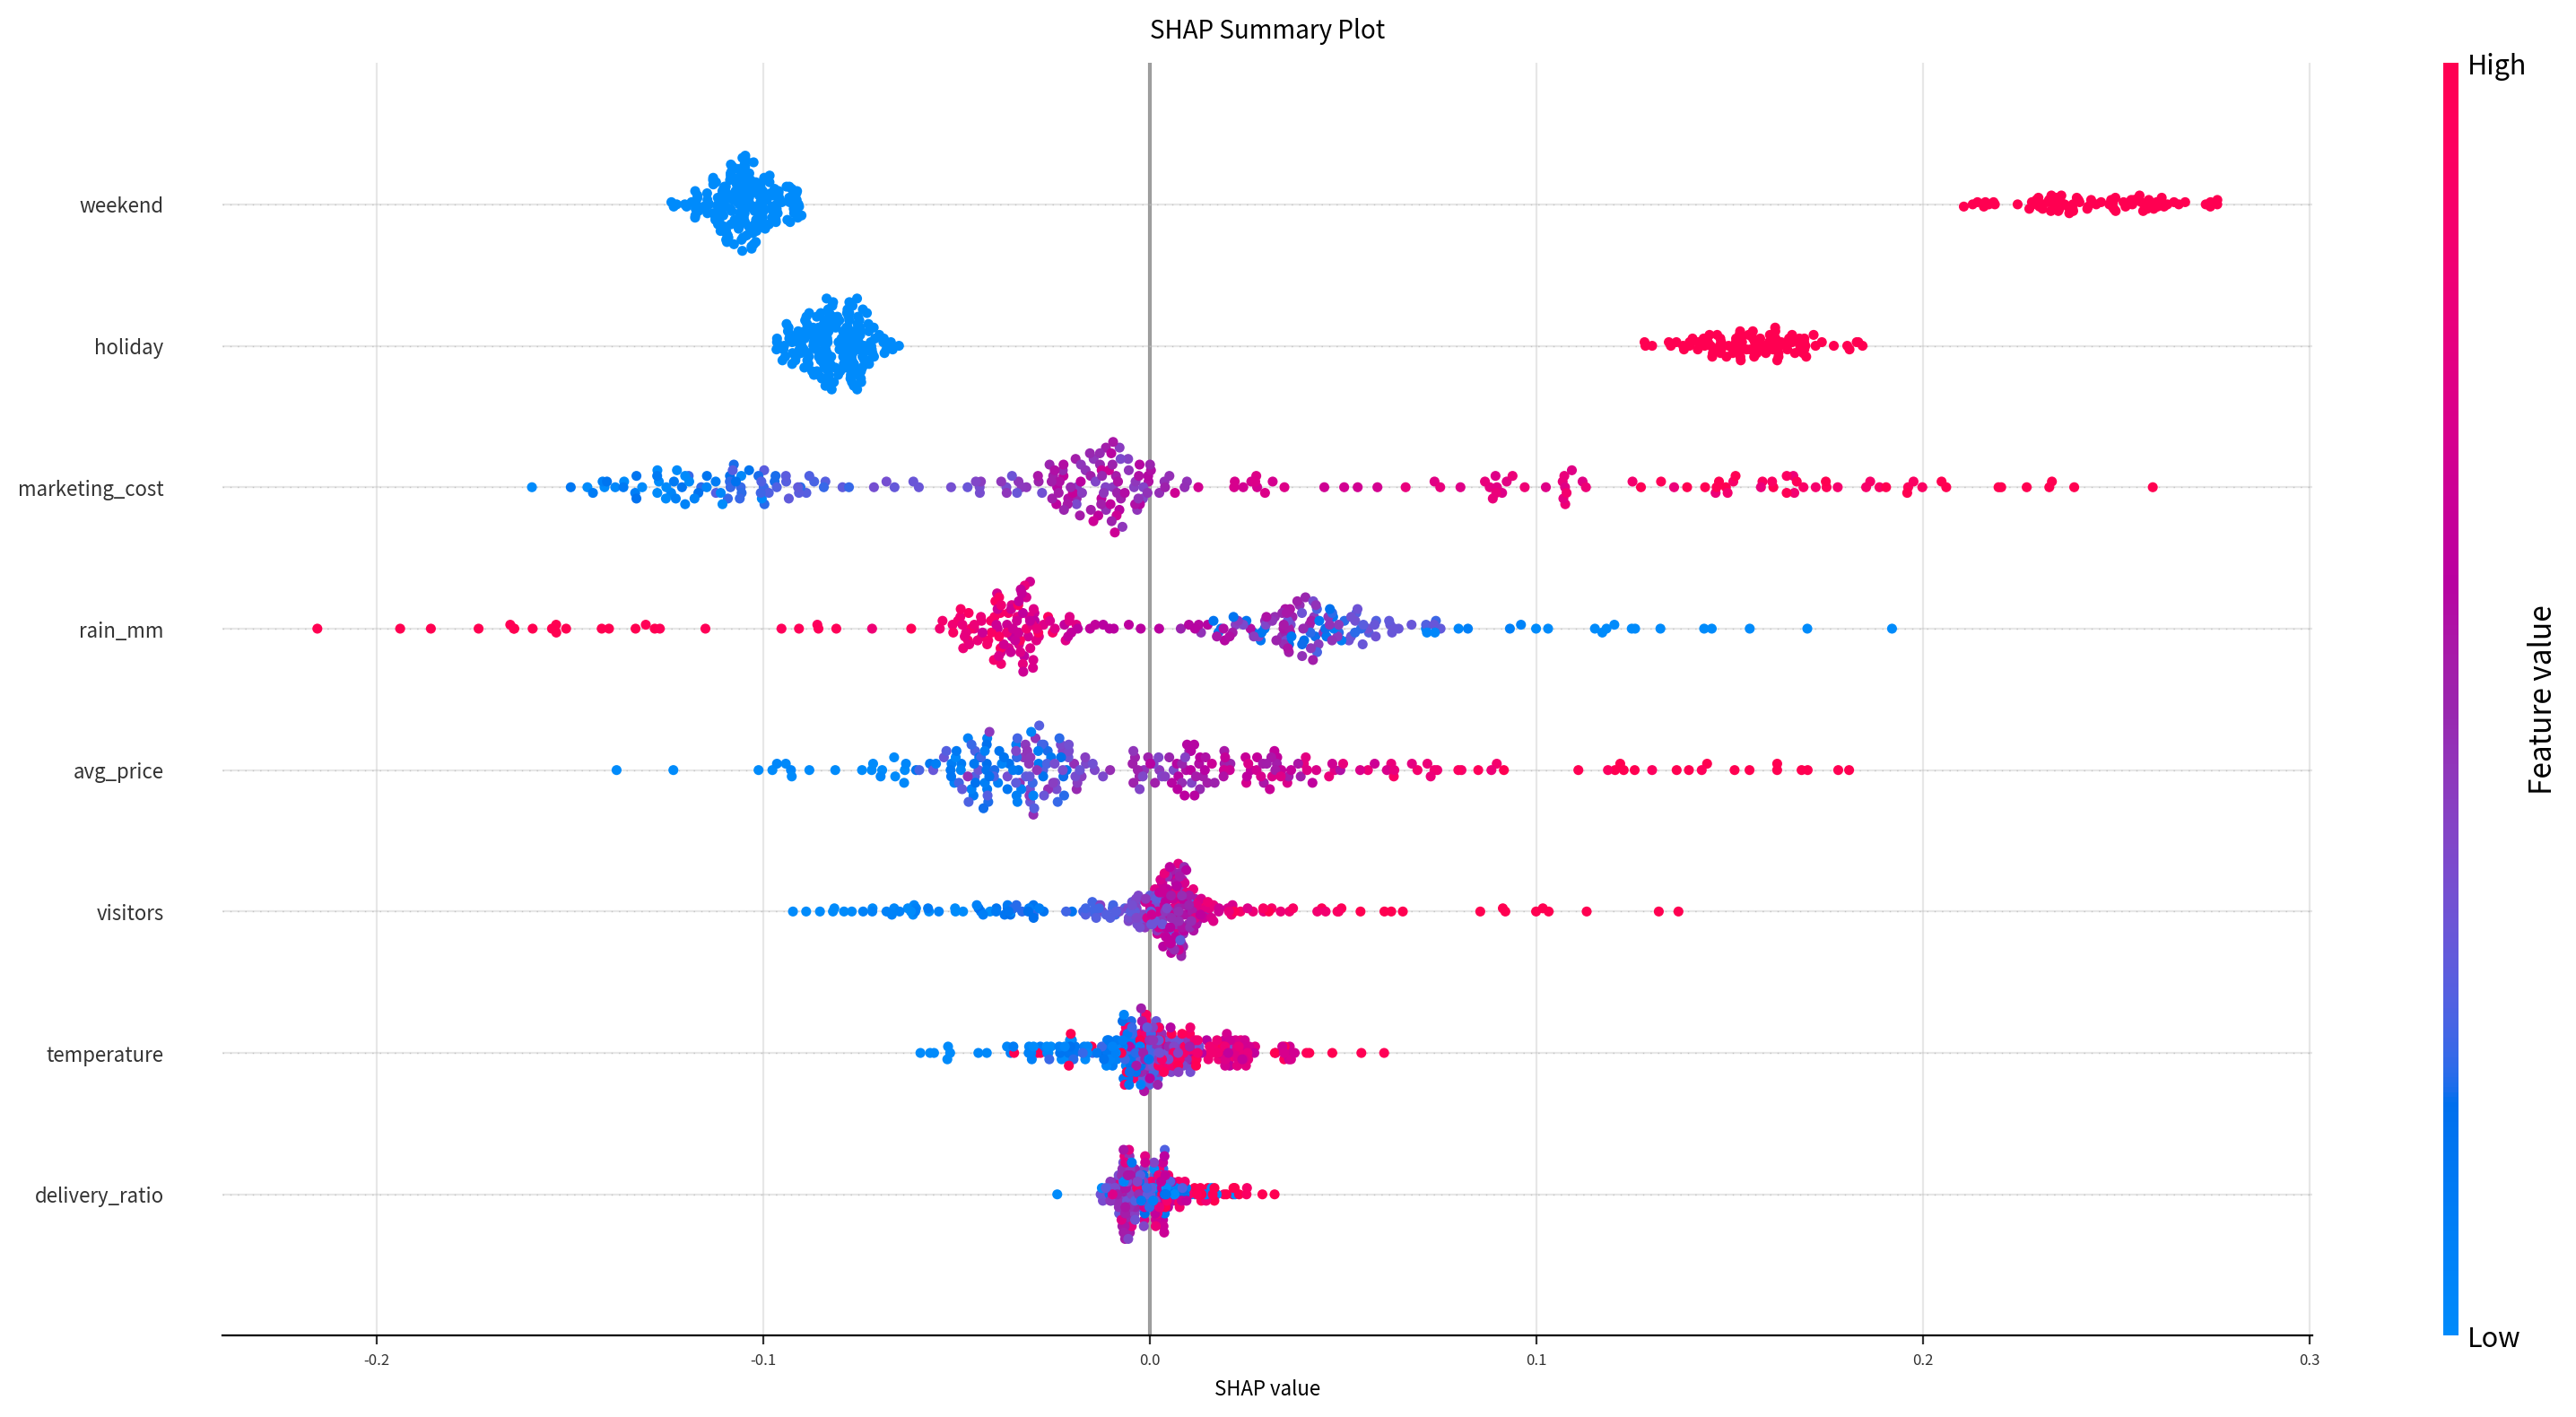

,feature,mean_abs_shap,mean_shap,std_shap,direction,cv,variability,importance_ratio,importance_cumsum,is_important
0,weekend,0.146,-0.000,0.160,음(-) 경향,1.095,variable,0.310,0.310,core
1,holiday,0.107,0.001,0.114,양(+) 경향,1.059,variable,0.227,0.537,core
2,marketing_cost,0.079,0.001,0.101,양(+) 경향,1.277,variable,0.167,0.704,core
3,rain_mm,0.053,-0.001,0.066,음(-) 경향,1.250,variable,0.112,0.817,secondary
4,avg_price,0.044,-0.000,0.057,음(-) 경향,1.302,variable,0.093,0.910,secondary
5,visitors,0.022,-0.000,0.034,음(-) 경향,1.562,variable,0.046,0.956,secondary
6,temperature,0.014,0.001,0.019,양(+) 경향,1.358,variable,0.030,0.986,secondary
7,delivery_ratio,0.006,0.000,0.008,양(+) 경향,1.293,variable,0.014,1.000,secondary


In [13]:
result, _ = hs_shap_analysis(best_model, x_train)
result